In [1]:
import os

from segment_anything import sam_model_registry
from ultralytics import YOLO

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt
import cv2
import json

## Load YOLO model, import distort params, define functions

In [3]:
model = YOLO('/home/mpgetz/repos/cocoon_classifier/yolo_train/runs/detect/train4/weights/best.pt')
with open('calibration.json', 'r') as file:
    calib = json.load(file)

mtx = np.array(calib['mtx'])
dist = np.array(calib['dist'])
newcameramtx = np.array(calib['newcameramtx'])

image = cv2.imread('data/cocoon_ims/img001.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h,  w = image.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def get_average_color(image, contour):
    # Create an all-zero mask of the same size as image
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    # Fill the detected contour in the mask with white color
    cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
    # Compute the average color
    average_color = cv2.mean(image, mask=mask)
    # Convert average color values from float to integer
    return tuple(map(int, average_color[:-1]))  # Discard the alpha value if any



FileNotFoundError: [Errno 2] No such file or directory: 'calibration.json'

## Load SAM model

In [8]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda")
predictor = SamPredictor(sam)

## TEST RUN


image 1/1 /home/mpgetz/repos/sam/img001.jpg: 480x640 1 cocoon, 3.0ms
Speed: 16.5ms preprocess, 3.0ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)
/tmp/ipykernel_813414/34719219.py:31: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


<Figure size 1000x1000 with 0 Axes>

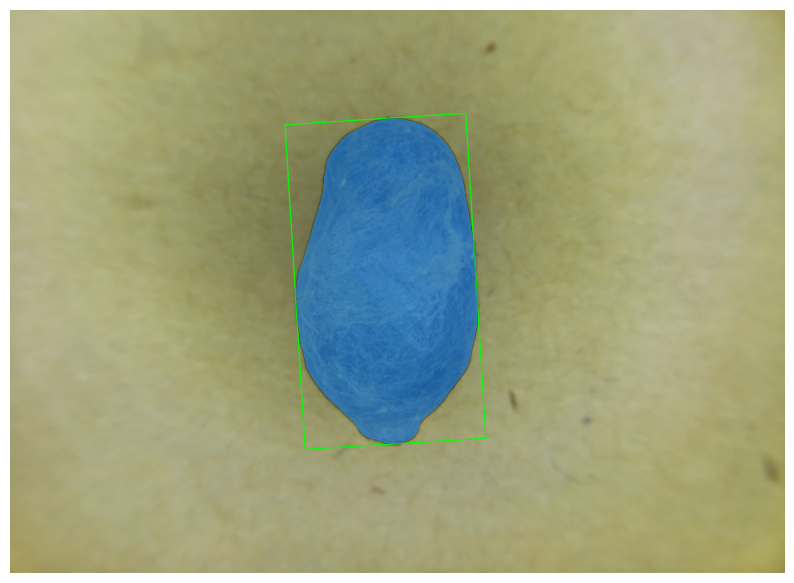

In [17]:
results = model('img001.jpg')
for r in results:
    im_array = r.plot(labels=False, line_width=1)  
    im = Image.fromarray(im_array[..., ::-1]) 
    plt.figure(figsize=(10,10))
    input_box = r.boxes.xyxy.cpu().numpy()
    if len(input_box) > 0:
        input_box = r.boxes.xyxy.cpu().numpy()[0]
        image = cv2.imread('img001.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        dst = cv2.undistort(image, mtx, dist, None, newcameramtx) # UNDISTORT
        x, y, w, h = roi
        image = dst[y:y+h, x:x+w]

    
        predictor.set_image(image)

        masks, _, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],
            multimask_output=False,
        )

        # GET BOUNDING RECTANGLE
        mask = np.where(masks[0], 255, 0).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours)> 0:
            rect = cv2.minAreaRect(contours[0])
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            image_with_rectangle = cv2.drawContours(image.copy(), [box], 0, (0, 255, 0), 2)

            avg_color = get_average_color(image, contours[0])
            print(avg_color)
        else:
            print('no contours')


        #plt.ioff()
        plt.figure(figsize=(10,10))
        plt.imshow(image_with_rectangle)
        
        show_mask(masks, plt.gca())
        #show_points(input_point, input_label, plt.gca())
        plt.axis('off')
        #plt.savefig(os.path.join(out_dir, f'{img[:-4]}_masked.jpg'))
        #plt.close()

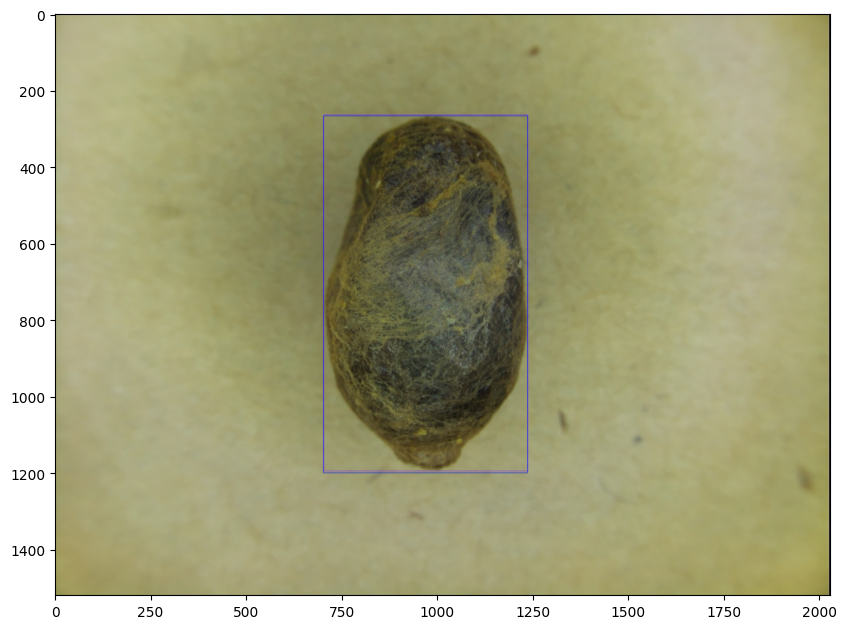

In [5]:
for r in results:
    im_array = r.plot(labels=False, line_width=1)  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    plt.figure(figsize=(10,10))
    plt.imshow(im)
    input_box = r.boxes.xyxy.cpu().numpy()[0]
    break

In [6]:
from segment_anything import sam_model_registry, SamPredictor


sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [7]:


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    



In [8]:


image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


predictor.set_image(image)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

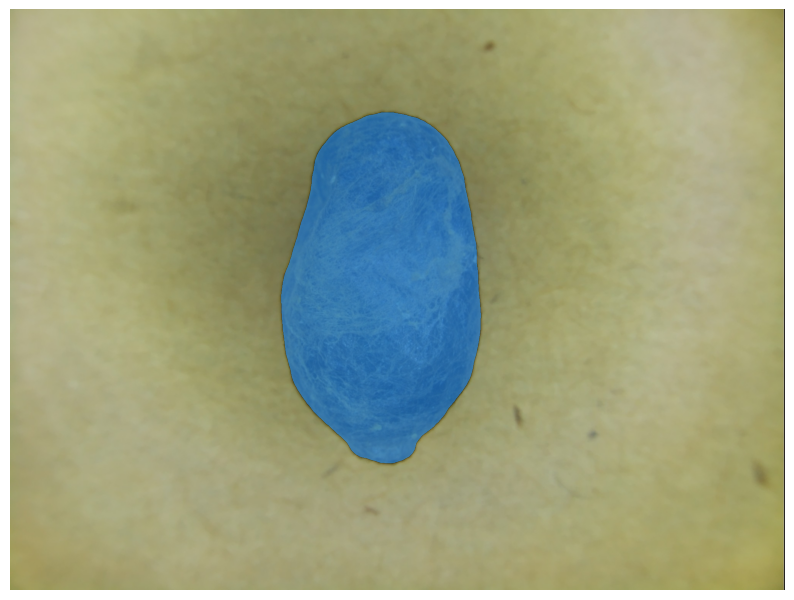

In [9]:


plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
#show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 





In [10]:
model = YOLO('yolov8n.pt')

from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda")
predictor = SamPredictor(sam)


In [11]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [6]:
file_list = os.listdir('data/cocoon_ims')
file_list = ['data/cocoon_ims/'+x for x in file_list]
out_dir = 'output/masked_imgs'
plt.ioff()

# file_list = ['cocoon_ims/ruler.jpg']

for img in file_list:
    results = model(img)
    for r in results:
        im_array = r.plot(labels=False, line_width=1)  
        im = Image.fromarray(im_array[..., ::-1]) 
        plt.figure(figsize=(10,10))
        input_box = r.boxes.xyxy.cpu().numpy()
        if len(input_box) > 0:
            input_box = r.boxes.xyxy.cpu().numpy()[0]
            image = cv2.imread(img)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            predictor.set_image(image)

            masks, _, _ = predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=False,
            )

            plt.figure(figsize=(10,10))
            plt.imshow(image)
            plt.ioff()
            show_mask(masks, plt.gca())
            #show_points(input_point, input_label, plt.gca())
            plt.axis('off')
            plt.savefig(os.path.join(out_dir, f'{img[:-4]}_masked.jpg'))
            plt.close()
        else:
            print(f'box not found in {img}')

            image = cv2.imread(img)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            predictor.set_image(image)

            input_point = np.array([[1030,800]])
            input_label = np.array([1])

            masks, scores, logits = predictor.predict(
                point_coords=input_point,
                point_labels=input_label,
                multimask_output=True,
            )

            mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask
            masks, _, _ = predictor.predict(
                point_coords=input_point,
                point_labels=input_label,
                mask_input=mask_input[None, :, :],
                multimask_output=False,
            )
            
            plt.figure(figsize=(10,10))
            plt.imshow(image)
            plt.ioff()
            show_mask(masks, plt.gca())
            #show_points(input_point, input_label, plt.gca())
            plt.axis('off')
            plt.savefig(os.path.join(out_dir, f'{img[:-4]}_masked.jpg'))
            plt.close()





image 1/1 /home/mpgetz/repos/sam/data/cocoon_ims/img025.jpg: 480x640 1 cocoon, 38.1ms
Speed: 7.5ms preprocess, 38.1ms inference, 17.2ms postprocess per image at shape (1, 3, 480, 640)


NameError: name 'predictor' is not defined

<Figure size 1000x1000 with 0 Axes>

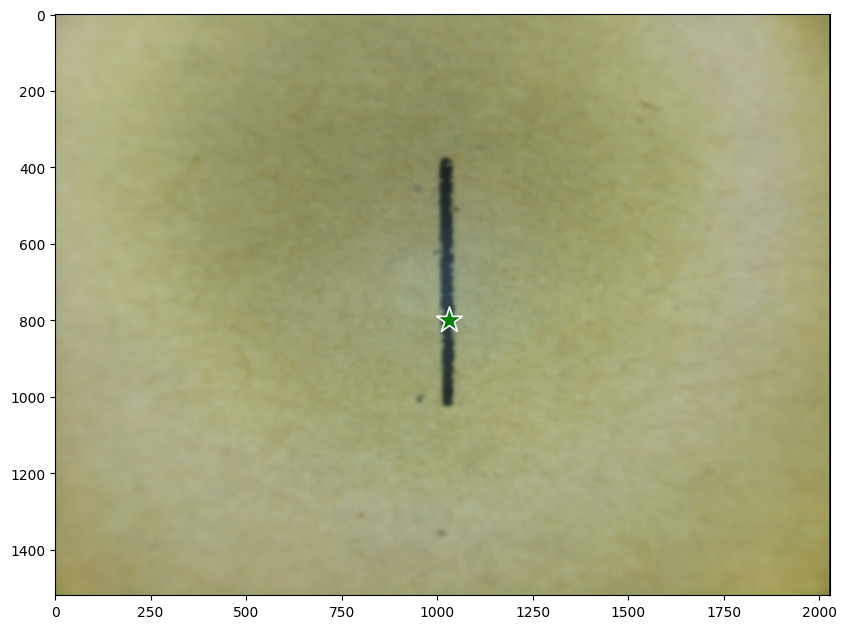

In [25]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

image = cv2.imread('cocoon_ims/ruler.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)




predictor.set_image(image)


# input_point = np.array([[1000, 800], [1000,500]])
# input_label = np.array([1, 1])
input_point = np.array([[1030, 800]])
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()



In [ ]:

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask



masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)



masks.shape




(1, 1520, 2028)

In [35]:


plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')




(-0.5, 2027.5, 1519.5, -0.5)

In [43]:
plt.close('all')

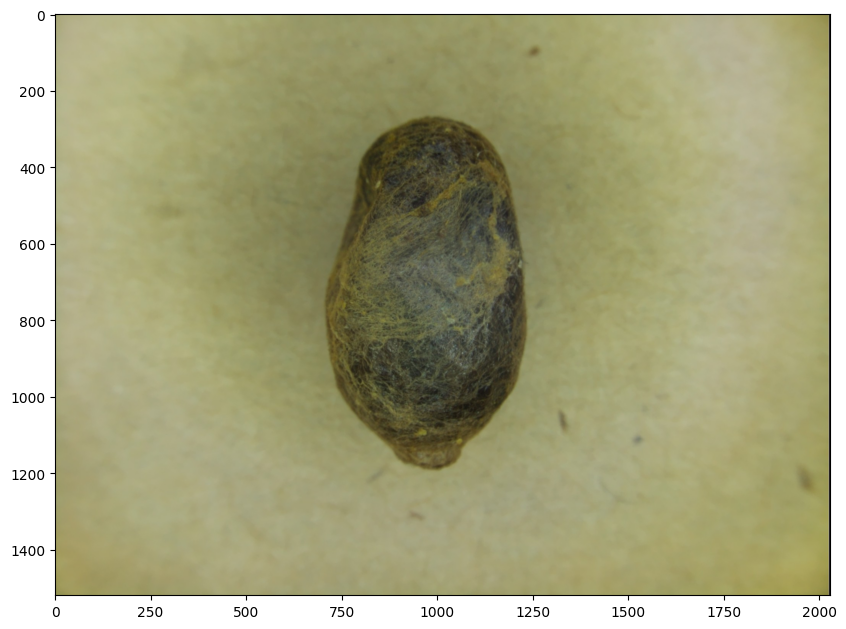

In [44]:
with open('calibration.json', 'r') as file:
    calib = json.load(file)

mtx = np.array(calib['mtx'])
dist = np.array(calib['dist'])
newcameramtx = np.array(calib['newcameramtx'])

image = cv2.imread('cocoon_ims/img001.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h,  w = image.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

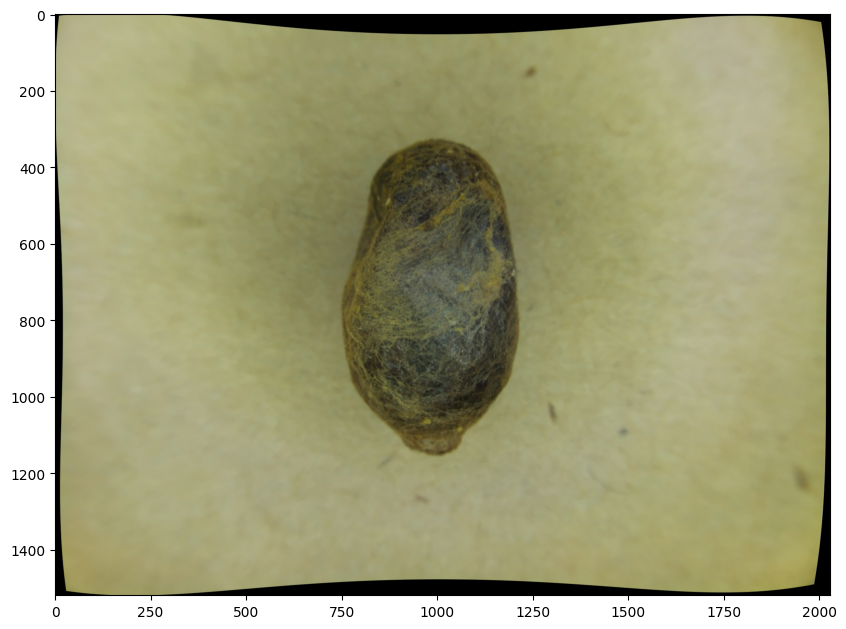

In [45]:
dst = cv2.undistort(image, mtx, dist, None, newcameramtx)
x, y, w, h = roi
# dst = dst[y:y+h, x:x+w]
plt.figure(figsize=(10,10))
plt.imshow(dst)
plt.show()